<a href="https://colab.research.google.com/github/arthanusamn/payment/blob/main/WB_JHan_1003.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 align="center">WB DS Take Home Project - Customer Churn Prediction</h1> 

<h3 align="center">Jixiong Han</h3> 

<h3 align="center">Oct 02, 2021</h3> 



# Contents

## 1. Introduction
### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1.1 Dataset
### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1.2 Objectives
## 2. Data Exploration and Processing
### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.1 Import Packages and Data
### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.2 Data Exploration
### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.3 Data Pre-Processing
## 3. RFM Apporach
## 4. Machine Learning Apporach
### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;4.1 Define Churn
### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;4.2 Feature Engineering
### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;4.3 Data Visulization
### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;4.4 Handle Imbalanced Data
### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;4.5 Machine Learning Models
### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;4.6 Feature Importance
### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;4.7 ROC Curve
## 5. Conclusions
## 6. References






## 1. Introduction



### 1.1 Datasets

<font size="4">
   
In this report I present findings from a customer payment dataset which has over 5000 merchants's transactions records over a span of three years. This dataset only has three columns. 

merchant: customer id, no real meaning
    
time: payment time stamp
    
amount_usd_in_cents: total amount of charge in one transaction</font>


### 1.2 Objectives

<font size="4">
Several things we want to understand: <br>
       
1) how to segment the merchants in the transactions data. 
    
2) how to predict which merchant might become inactive soon (churn).</font>

## 2. Data Exploration

### 2.1 Import Packages and Read Data

In [19]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [20]:
%cd /content/drive/My Drive/Colab Notebooks/

/content/drive/My Drive/Colab Notebooks


In [21]:
# import basics packages. ML packages will be imported in the later sections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import squarify
from datetime import datetime
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')

# read csv
pay = pd.read_csv("payments_data.csv", parse_dates= ['time'])

In [22]:
pip install wandb


In [23]:
import wandb

In [24]:
wandb.login()

wandb: Currently logged in as: hanjixiong (use `wandb login --relogin` to force relogin)


True

### 2.2 Data Exploration

In [25]:
# quick look
pay.head()

,merchant,time,amount_usd_in_cents
0,1c8b539073,2033-03-10 18:46:49,715
1,4647d230cc,2034-04-29 02:19:37,8010
2,4f65280858,2034-03-17 04:03:32,11731
3,4a98a5cdc1,2033-02-21 13:00:11,3486
4,06fe79e266,2034-12-01 16:56:37,2314


In [26]:
# size and dim of the data
pay.shape

(544831, 3)

In [27]:
# info is very handy for overview
pay.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 544831 entries, 0 to 544830
Data columns (total 3 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   merchant             544831 non-null  object        
 1   time                 544831 non-null  datetime64[ns]
 2   amount_usd_in_cents  544831 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 12.5+ MB


In [28]:
# double check on nulls
pay.isna().any()

merchant               False
time                   False
amount_usd_in_cents    False
dtype: bool

In [29]:
# how many unique customers
pay["merchant"].nunique()

5000

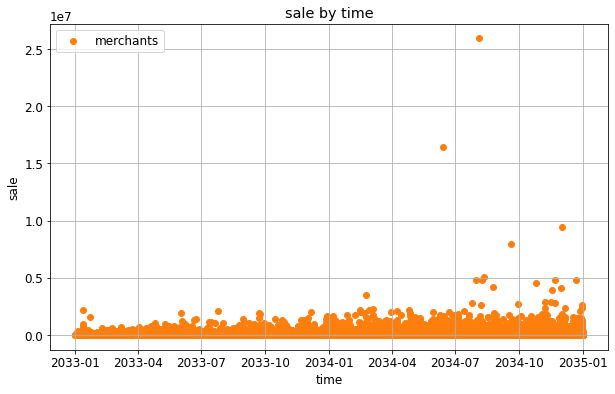

In [30]:
# quick visulization. Looks like businsses is on track. Sale is increasing over the time.
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(10, 6))

# scatter plot
ax.scatter(pay.time, pay.amount_usd_in_cents, color='tab:orange', label='merchants')

# same as above
ax.set_xlabel('time')
ax.set_ylabel('sale')
ax.set_title('sale by time')
ax.grid(True)
ax.legend(loc='upper left');

### 2.3 Data Pre-Processing 

In [31]:
# parse the timestamp
dt_format_str = '%Y-%m-%d %H:%M:%S'
pd.to_datetime(
            pay.time, 
            format=dt_format_str, errors='coerce'
        )

# add year, quarter, month, week and day
pay['year'] = pay['time'].dt.year
pay['quarter'] = pay['time'].dt.quarter
pay['month'] = pay['time'].dt.month
pay['week'] = pay['time'].dt.week
pay['day'] = pay['time'].dt.day

# check
pay.head()

,merchant,time,amount_usd_in_cents,year,quarter,month,week,day
0,1c8b539073,2033-03-10 18:46:49,715,2033,1,3,10,10
1,4647d230cc,2034-04-29 02:19:37,8010,2034,2,4,17,29
2,4f65280858,2034-03-17 04:03:32,11731,2034,1,3,11,17
3,4a98a5cdc1,2033-02-21 13:00:11,3486,2033,1,2,8,21
4,06fe79e266,2034-12-01 16:56:37,2314,2034,4,12,48,1


## 3. RFM Model

<font size="4">
More information on RFM model could be found from this site: 
    https://searchdatamanagement.techtarget.com/definition/RFM-analysis<br>
    <br>
Basically, RFM (recency, frequency, monetary) analysis is a marketing technique used to quantiatively rank and group customers based on the recency, frequency and monetary total of their recent transactions to indentify the best customers and perform target marketing campasigns. We will apply RFM model to our dataset to identify "Churn" customer for our next Machine learning work.
    
Recency — number of days since the last purchase

Frequency — number of transactions made over a given period

Monetary — amount spent over a given period of time</font>





In [32]:
# create Recency, Frequency and MonetaryValue Metrics

# set now date
Now = pay['time'].max() + timedelta(days=1)
print(Now)

# grouping by customer
data_process = pay.groupby(['merchant']).agg({
            'time': lambda x: (Now - x.max()).days,
            'merchant':'count',
            'amount_usd_in_cents':'sum'})

# rename the columns
data_process.rename(columns={'time':'Recency',
                             'merchant':'Frequency',
                             'amount_usd_in_cents':'Monetary'}, inplace=True)

# check
data_process.head()

2035-01-01 07:59:40


,Recency,Frequency,Monetary
merchant,,,
000f8c3297,1,290,3455191
00575c7901,1,9860,67935727
00607c6461,10,1,50094
0063ff0c6b,42,28,1096174
007364b02a,417,3,60880


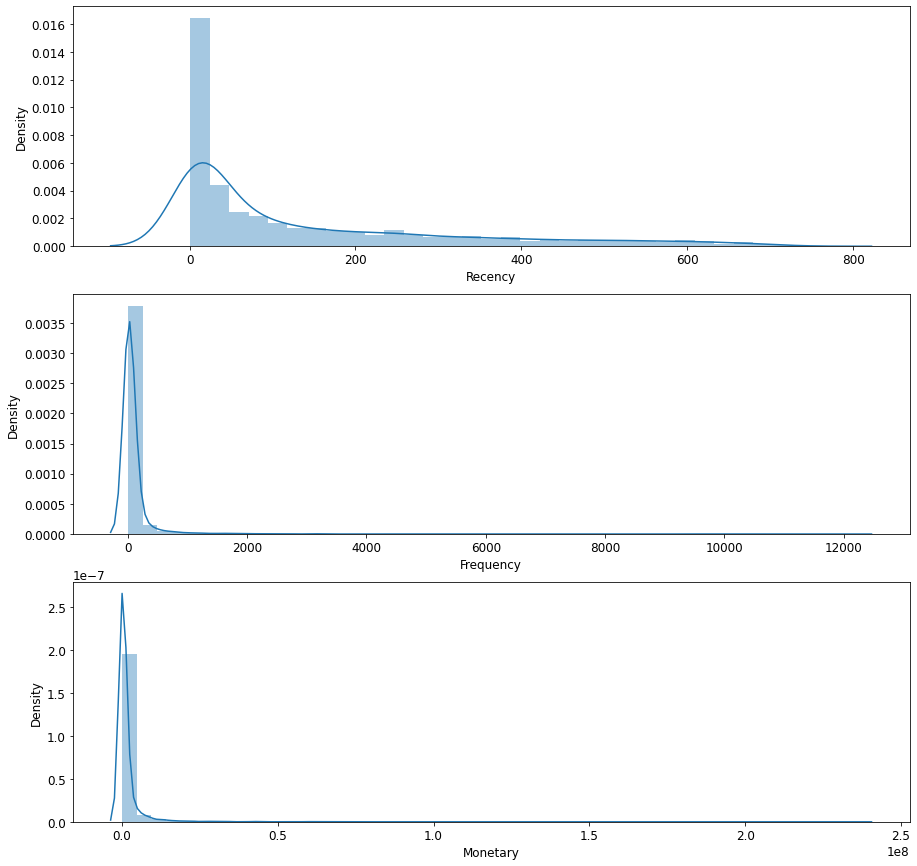

In [33]:
# quick data visu on the rfm table

plt.figure(figsize=(15,15))

# plot distribution of R
plt.subplot(3, 1, 1); sns.distplot(data_process['Recency'])

# plot distribution of F
plt.subplot(3, 1, 2); sns.distplot(data_process['Frequency'])

# plot distribution of M
plt.subplot(3, 1, 3); sns.distplot(data_process['Monetary'])

# show the plot
plt.show()


<font size="4">
Our data is very skewed which is not a total surprise. We will group these values in quantiles and seperate them into different customer segments.</font>

In [34]:
# calculate R, F, M groups

# create labels for Recency, Frequency and Monetary
r_labels = range(4, 0, -1); f_labels = range(1,5); m_labels = range(1,5)

# assign these labels to 4 equal percentile groups 
r_groups = pd.qcut(data_process['Recency'], q=4, labels=r_labels)

# assign these labels to 4 equal percentile groups 
f_groups = pd.qcut(data_process['Frequency'], q=4, labels=f_labels)

# assign these labels to three equal percentile groups 
m_groups = pd.qcut(data_process['Monetary'], q=4, labels=m_labels)

# create new columns R, F and M
data_process = data_process.assign(R = r_groups.values, F = f_groups.values, M=m_groups.values)

# check
data_process.head()

,Recency,Frequency,Monetary,R,F,M
merchant,,,,,,
000f8c3297,1,290,3455191,4,4,4
00575c7901,1,9860,67935727,4,4,4
00607c6461,10,1,50094,4,1,2
0063ff0c6b,42,28,1096174,3,3,4
007364b02a,417,3,60880,1,1,2



<font size="4">
With these 3 scores in RFM, we can create the RFM segment by concatenating the values together below.</font>



In [35]:
# concat RFM quartile values to create RFM Segments
def join_rfm(x): return str(x['R']) + str(x['F']) + str(x['M'])
data_process['RFM_Segment_Concat'] = data_process.apply(join_rfm, axis=1)
rfm = data_process

# check
rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment_Concat
merchant,,,,,,,
000f8c3297,1,290,3455191,4,4,4,444
00575c7901,1,9860,67935727,4,4,4,444
00607c6461,10,1,50094,4,1,2,412
0063ff0c6b,42,28,1096174,3,3,4,334
007364b02a,417,3,60880,1,1,2,112



<font size="4">
We are ready for customer segmentation but there might be too many groups at this moment...</font>

In [36]:
# count num of unique segments
rfm_count_unique = rfm.groupby('RFM_Segment_Concat')['RFM_Segment_Concat'].nunique()
print(rfm_count_unique.sum())

61


<font size="4">
61 groups! This is way too many. So we may have to take a different apporach by summarizing the RFM scores and define RFM levels for each score range.</font>

In [37]:
# summing the RFM score

rfm['RFM_Score'] = rfm[['R','F','M']].sum(axis=1)
print(rfm['RFM_Score'].head())

merchant
000f8c3297    12
00575c7901    12
00607c6461     7
0063ff0c6b    10
007364b02a     4
Name: RFM_Score, dtype: int64


In [38]:
# count num of unique segments
rfm_score_unique = rfm.groupby('RFM_Score')['RFM_Score'].nunique()
print(rfm_score_unique.sum())

10


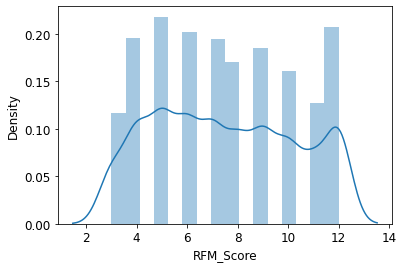

In [39]:
# quick visu

sns.distplot(rfm['RFM_Score'])

<font size="4">
Now we are ready to group the customer to different level based on the RFM scores</font>

In [40]:
# define rfm_level function
def rfm_level(df):
    if df['RFM_Score'] >= 10:
        return 'VIP'
    elif ((df['RFM_Score'] >= 8) and (df['RFM_Score'] < 10)):
        return 'Loyal'
    elif ((df['RFM_Score'] >= 6) and (df['RFM_Score'] < 8)):
        return 'Good'
    elif ((df['RFM_Score'] >= 4) and (df['RFM_Score'] < 6)):
        return 'Potential'
    else:
        return 'Churn'
    
# create a new variable RFM_Level
rfm['RFM_Level'] = rfm.apply(rfm_level, axis=1)

# print the header with top 5 rows to the console
rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment_Concat,RFM_Score,RFM_Level
merchant,,,,,,,,,
000f8c3297,1,290,3455191,4,4,4,444,12,VIP
00575c7901,1,9860,67935727,4,4,4,444,12,VIP
00607c6461,10,1,50094,4,1,2,412,7,Good
0063ff0c6b,42,28,1096174,3,3,4,334,10,VIP
007364b02a,417,3,60880,1,1,2,112,4,Potential


<font size="4">
Creating RFM summary report</font>

In [41]:
# calculate average values for each RFM_Level, and return a size of each segment 
rfm_level_agg = rfm.groupby('RFM_Level').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
}).round(1)

# print the aggregated dataset
print(rfm_level_agg)

          Recency Frequency   Monetary      
             mean      mean       mean count
RFM_Level                                   
Churn       419.3       1.7    15173.2   328
Good        155.2      10.2   202139.3  1117
Loyal        98.9      41.3   786869.1   999
Potential   225.5       3.4    48386.7  1162
VIP          14.1     349.8  4990592.5  1394


<font size="4">
And some visulization</font>

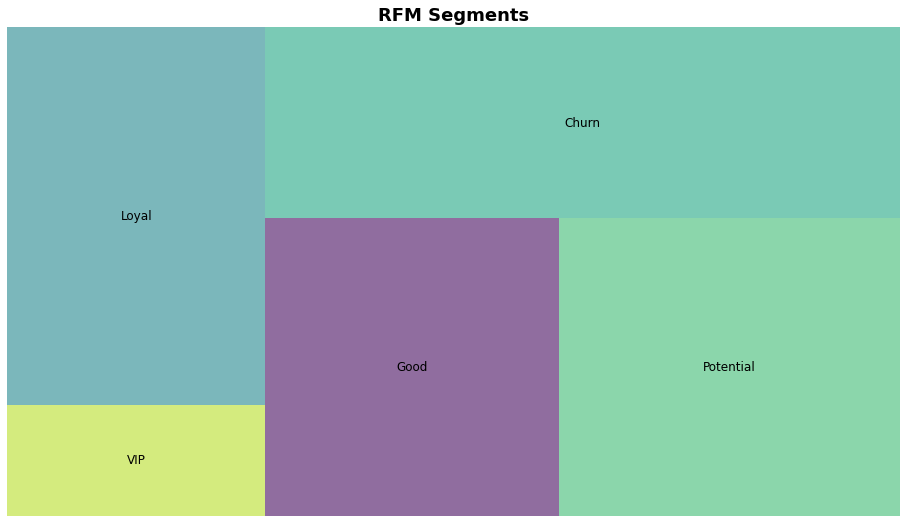

In [42]:
# rfm model visulization

# rfm_level_agg.columns = rfm_level_agg.columns.droplevel()
rfm_level_agg.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count']
#Create our plot and resize it.
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 9)
squarify.plot(sizes=rfm_level_agg['Count'], 
              label=['VIP',
                     'Loyal',
                     'Good',
                     'Potential', 
                     'Churn'], alpha=.6 )
plt.title("RFM Segments",fontsize=18,fontweight="bold")
plt.axis('off')
plt.show()

<font size="4">
It seems the business is on track. Majority of customer are receiving decent RFM scores and in the top levels. But more work might be needed on the churn and potential churn groups.<br><br>
    
This concludes the 3rd section RFM model. Our next section is ML prediction.</font>

## 4. Machine Learning

### 4.1 Define Churn

<font size="4">
Our dataset is unlabeled there is no target column. We have to define the churn ourselves. Customer churn happens when customers decide to not continue purchasing products/services from an organization and end their association.<br> 
    
And if we go back to our RFM model you can see there is a signficant difference in terms RFM values between potential vs churn groups. The Recency mean of potential group is 226days(around 7month) and the Recency mean of churn group is 419days (around 14 months). Based on all these info. We decided to pick 365days (~1 year) as the criteria. So here is the our definition on this dataset for customer churn

    if no transaction in <365 days then churn = yes else churn = no
                              
Note: this is a bit subjective but might make sense because many of business do annual subscription.</font>

In [43]:
# define churn 

# it's kind of subjective but we will use >365day not transactions as the critiera for churn

# define churn function
def churn(df):
    if df['Recency'] >= 365:
        return 1
    else:
        return 0
    
# create a new column churn
rfm['Churn'] = rfm.apply(churn, axis=1)

# check
rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment_Concat,RFM_Score,RFM_Level,Churn
merchant,,,,,,,,,,
000f8c3297,1,290,3455191,4,4,4,444,12,VIP,0
00575c7901,1,9860,67935727,4,4,4,444,12,VIP,0
00607c6461,10,1,50094,4,1,2,412,7,Good,0
0063ff0c6b,42,28,1096174,3,3,4,334,10,VIP,0
007364b02a,417,3,60880,1,1,2,112,4,Potential,1


<font size="4">
And a quick visulization</font>

Text(0.5, 1.0, 'Monetary')

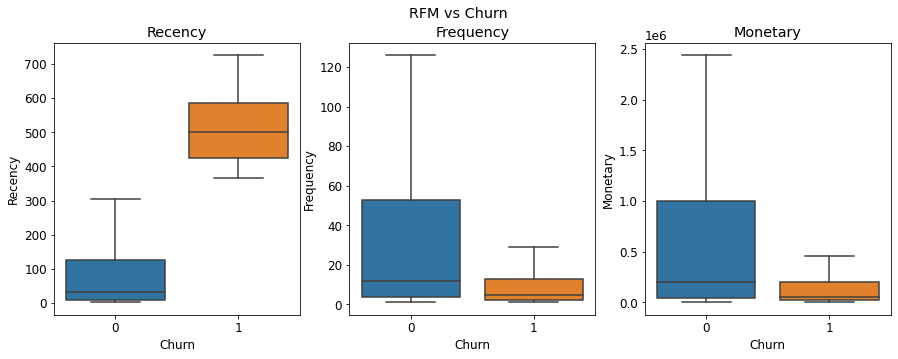

In [44]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('RFM vs Churn')

# Recency
sns.boxplot(ax=axes[0], x='Churn', y='Recency', data=rfm, sym="",)
axes[0].set_title('Recency')

# Frequency
sns.boxplot(ax=axes[1], x='Churn', y='Frequency', data=rfm, sym="",)
axes[1].set_title('Frequency')

# Monetary
sns.boxplot(ax=axes[2], x='Churn', y='Monetary', data=rfm, sym="",)
axes[2].set_title('Monetary')

<font size="4">
It's interesting to see churn group not only has much longer Recency, but also smaller frequency and monetary.</font>

### 4.2 Feature Engineering 

<font size="4">
Additional feature engineering is needed to create more useful features for Machine Learning models. We want to aggregate the transactions in a way to retrieve useful information.</font>

In [45]:
# back to our pay dataset

# add year_quarter so we could summarize the sale on a quarterly basis for each customer
pay["year_quarter"] = pay["year"].astype(str)+ "_" + pay["quarter"].astype(str)

# check
pay.head()

,merchant,time,amount_usd_in_cents,year,quarter,month,week,day,year_quarter
0,1c8b539073,2033-03-10 18:46:49,715,2033,1,3,10,10,2033_1
1,4647d230cc,2034-04-29 02:19:37,8010,2034,2,4,17,29,2034_2
2,4f65280858,2034-03-17 04:03:32,11731,2034,1,3,11,17,2034_1
3,4a98a5cdc1,2033-02-21 13:00:11,3486,2033,1,2,8,21,2033_1
4,06fe79e266,2034-12-01 16:56:37,2314,2034,4,12,48,1,2034_4


<font size="4">
We could summarize the customer transaction to yearly, monthly or weekly. But we decide to use quarterly at this time.</font>

In [46]:
# agg the sale to quarterly
temp_pay = pay.groupby(['merchant','year_quarter'], 
                      as_index=False).agg({'amount_usd_in_cents':['sum','mean','max','min','count']})

temp_pay.round(2)

merchant year_quarter amount_usd_in_cents  ...                     
                                               sum  ...     max    min count
0      000f8c3297       2033_3               22889  ...   22889  22889     1
1      000f8c3297       2033_4              162190  ...   23136   6108    16
2      000f8c3297       2034_1              457902  ...   47255   3171    29
3      000f8c3297       2034_2              698974  ...   34761   1981    74
4      000f8c3297       2034_3              788629  ...   29570   3202    68
...           ...          ...                 ...  ...     ...    ...   ...
13695  ffb94e1865       2034_4            22030602  ...  395590   1109  2773
13696  ffc06f74ff       2034_3               10235  ...    8681   1554     2
13697  fff1754102       2033_3               27150  ...   27150  27150     1
13698  fff1754102       2034_3              489203  ...   46557   3452    42
13699  fff1754102       2034_4               17342  ...    9180   4077     3

[13700 rows x 7 columns]

In [47]:
# clean up the table
temp_pay.columns = [
'_'.join(col).rstrip('_') for col in temp_pay.columns.values
]

temp_pay.head()

,merchant,year_quarter,amount_usd_in_cents_sum,amount_usd_in_cents_mean,amount_usd_in_cents_max,amount_usd_in_cents_min,amount_usd_in_cents_count
0,000f8c3297,2033_3,22889,22889.000000,22889,22889,1
1,000f8c3297,2033_4,162190,10136.875000,23136,6108,16
2,000f8c3297,2034_1,457902,15789.724138,47255,3171,29
3,000f8c3297,2034_2,698974,9445.594595,34761,1981,74
4,000f8c3297,2034_3,788629,11597.485294,29570,3202,68


In [48]:
# rename the columns
temp_pay.rename(columns={'amount_usd_in_cents_sum':'totalspending',
                             'amount_usd_in_cents_mean':'avgspending',
                             'amount_usd_in_cents_max':'maxspending',
                             'amount_usd_in_cents_min':'minspending',
                             'amount_usd_in_cents_count':'transactions',
                       }, inplace=True)

In [49]:
temp_pay.head()

,merchant,year_quarter,totalspending,avgspending,maxspending,minspending,transactions
0,000f8c3297,2033_3,22889,22889.000000,22889,22889,1
1,000f8c3297,2033_4,162190,10136.875000,23136,6108,16
2,000f8c3297,2034_1,457902,15789.724138,47255,3171,29
3,000f8c3297,2034_2,698974,9445.594595,34761,1981,74
4,000f8c3297,2034_3,788629,11597.485294,29570,3202,68


<font size="4">
These are the customers' quartly totalspending, avgspending, maxspending, minspending and numbers of transactions. <br>
    
Next we will join the rfm table so we have the target label "churn" column for ML prediction.</font>

In [50]:
# merge two dfs 
merged_pay = pd.merge(temp_pay, rfm, on = 'merchant', how= 'left')

# check
merged_pay.head(10)

,merchant,year_quarter,totalspending,avgspending,maxspending,minspending,transactions,Recency,Frequency,Monetary,R,F,M,RFM_Segment_Concat,RFM_Score,RFM_Level,Churn
0,000f8c3297,2033_3,22889,22889.000000,22889,22889,1,1,290,3455191,4,4,4,444,12,VIP,0
1,000f8c3297,2033_4,162190,10136.875000,23136,6108,16,1,290,3455191,4,4,4,444,12,VIP,0
2,000f8c3297,2034_1,457902,15789.724138,47255,3171,29,1,290,3455191,4,4,4,444,12,VIP,0
3,000f8c3297,2034_2,698974,9445.594595,34761,1981,74,1,290,3455191,4,4,4,444,12,VIP,0
4,000f8c3297,2034_3,788629,11597.485294,29570,3202,68,1,290,3455191,4,4,4,444,12,VIP,0
5,000f8c3297,2034_4,1324607,12986.343137,40279,2680,102,1,290,3455191,4,4,4,444,12,VIP,0
6,00575c7901,2034_1,4812180,6442.008032,100432,2229,747,1,9860,67935727,4,4,4,444,12,VIP,0
7,00575c7901,2034_2,8823983,6357.336455,45070,1880,1388,1,9860,67935727,4,4,4,444,12,VIP,0
8,00575c7901,2034_3,17919251,6844.633690,70904,1972,2618,1,9860,67935727,4,4,4,444,12,VIP,0
9,00575c7901,2034_4,36380313,7123.617192,243899,206,5107,1,9860,67935727,4,4,4,444,12,VIP,0


<font size="4">
Looks good but all the RFM columns need to be deleted.</font>

In [51]:
# drop all rfm columns

merged_pay.drop(['Recency','Frequency','Monetary','R','F','M','RFM_Segment_Concat','RFM_Score','RFM_Level'], 
                axis=1, inplace=True)

# check
merged_pay.head()

,merchant,year_quarter,totalspending,avgspending,maxspending,minspending,transactions,Churn
0,000f8c3297,2033_3,22889,22889.000000,22889,22889,1,0
1,000f8c3297,2033_4,162190,10136.875000,23136,6108,16,0
2,000f8c3297,2034_1,457902,15789.724138,47255,3171,29,0
3,000f8c3297,2034_2,698974,9445.594595,34761,1981,74,0
4,000f8c3297,2034_3,788629,11597.485294,29570,3202,68,0


<font size="4">
One last step, maybe it's a good idea to add quarterly spending growth or decline rate for each customer. That's the totalspending change (either increase or decrease) for each quarter for each customer.</font>

In [52]:
# add additional columns of pct_change quarter over quarter
merged_pay['pct_qoq']=merged_pay.sort_values('year_quarter').groupby(['merchant']).totalspending.pct_change()

# check
merged_pay.head(10)

,merchant,year_quarter,totalspending,avgspending,maxspending,minspending,transactions,Churn,pct_qoq
0,000f8c3297,2033_3,22889,22889.000000,22889,22889,1,0,NaN
1,000f8c3297,2033_4,162190,10136.875000,23136,6108,16,0,6.085936
2,000f8c3297,2034_1,457902,15789.724138,47255,3171,29,0,1.823244
3,000f8c3297,2034_2,698974,9445.594595,34761,1981,74,0,0.526471
4,000f8c3297,2034_3,788629,11597.485294,29570,3202,68,0,0.128267
5,000f8c3297,2034_4,1324607,12986.343137,40279,2680,102,0,0.679633
6,00575c7901,2034_1,4812180,6442.008032,100432,2229,747,0,NaN
7,00575c7901,2034_2,8823983,6357.336455,45070,1880,1388,0,0.833677
8,00575c7901,2034_3,17919251,6844.633690,70904,1972,2618,0,1.030744
9,00575c7901,2034_4,36380313,7123.617192,243899,206,5107,0,1.030236


In [53]:
# first record of each customer will be NaN so need to be dropped
df=merged_pay.dropna()

# check
df.head(20)

,merchant,year_quarter,totalspending,avgspending,maxspending,minspending,transactions,Churn,pct_qoq
1,000f8c3297,2033_4,162190,10136.875000,23136,6108,16,0,6.085936
2,000f8c3297,2034_1,457902,15789.724138,47255,3171,29,0,1.823244
3,000f8c3297,2034_2,698974,9445.594595,34761,1981,74,0,0.526471
4,000f8c3297,2034_3,788629,11597.485294,29570,3202,68,0,0.128267
5,000f8c3297,2034_4,1324607,12986.343137,40279,2680,102,0,0.679633
7,00575c7901,2034_2,8823983,6357.336455,45070,1880,1388,0,0.833677
8,00575c7901,2034_3,17919251,6844.633690,70904,1972,2618,0,1.030744
9,00575c7901,2034_4,36380313,7123.617192,243899,206,5107,0,1.030236
12,0063ff0c6b,2034_2,249069,249069.000000,249069,249069,1,0,3.918910
13,0063ff0c6b,2034_3,774319,32263.291667,234103,557,24,0,2.108853


<font size="4">
Almost done. Final touch on data preprocessing/feature engineering. Drop some columns and re-arrange the order of columns.</font>

In [54]:
# drop merchant and year_quarter columns as they are not useful for model
df.drop(['merchant','year_quarter'],axis=1, inplace=True)

# re-arrange the columns
old_cols = df.columns.values
new_cols = ['totalspending','avgspending','maxspending','minspending','transactions','pct_qoq','Churn']
df=df.reindex(columns=new_cols)

# check
df.head(10)

,totalspending,avgspending,maxspending,minspending,transactions,pct_qoq,Churn
1,162190,10136.875000,23136,6108,16,6.085936,0
2,457902,15789.724138,47255,3171,29,1.823244,0
3,698974,9445.594595,34761,1981,74,0.526471,0
4,788629,11597.485294,29570,3202,68,0.128267,0
5,1324607,12986.343137,40279,2680,102,0.679633,0
7,8823983,6357.336455,45070,1880,1388,0.833677,0
8,17919251,6844.633690,70904,1972,2618,1.030744,0
9,36380313,7123.617192,243899,206,5107,1.030236,0
12,249069,249069.000000,249069,249069,1,3.918910,0
13,774319,32263.291667,234103,557,24,2.108853,0


### 4.3 Data Visulization

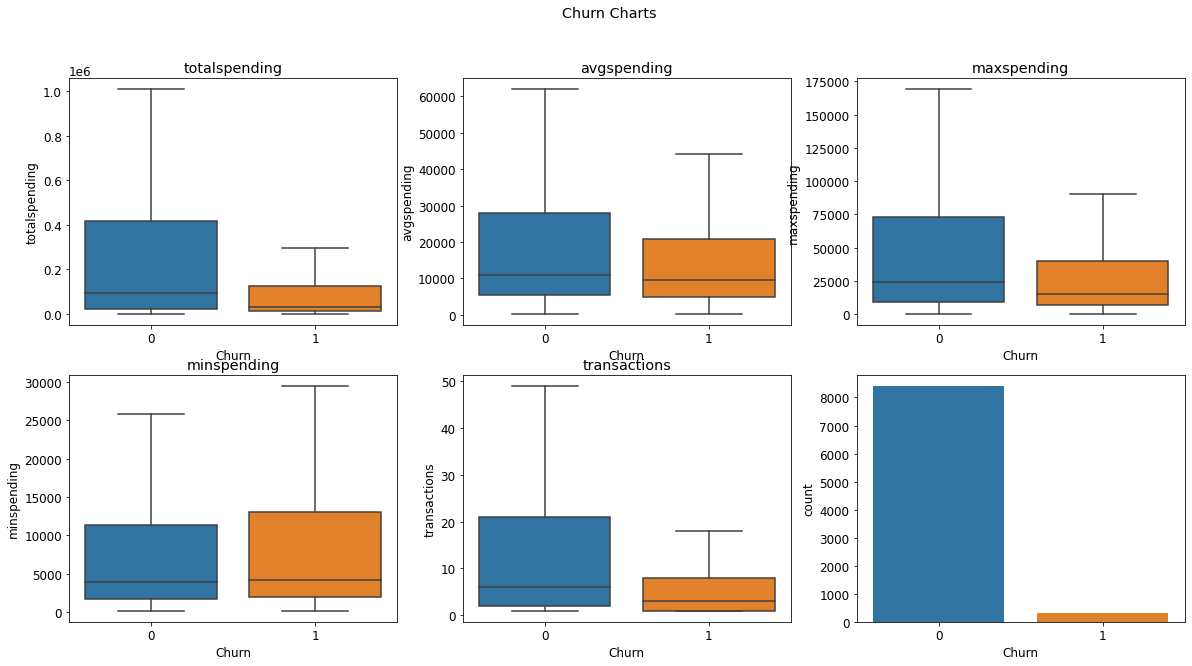

In [55]:
# data visulization to better understand our processed data

fig, axes = plt.subplots(2, 3, figsize=(20, 10))
fig.suptitle('Churn Charts')

# totalspending
sns.boxplot(ax=axes[0,0], x='Churn', y='totalspending', data=merged_pay, sym="",)
axes[0,0].set_title('totalspending')

# avgspending
sns.boxplot(ax=axes[0,1], x='Churn', y='avgspending', data=merged_pay, sym="",)
axes[0,1].set_title('avgspending')

# maxspending
sns.boxplot(ax=axes[0,2], x='Churn', y='maxspending', data=merged_pay, sym="",)
axes[0,2].set_title('maxspending')

# minspending
sns.boxplot(ax=axes[1,0], x='Churn', y='minspending', data=merged_pay, sym="",)
axes[1,0].set_title('minspending')

# num of transactions
sns.boxplot(ax=axes[1,1], x='Churn', y='transactions', data=merged_pay, sym="",)
axes[1,1].set_title('transactions')

# churn vs no churn
sns.countplot(x='Churn', data=df)

<font size="4">
It's interesting to see some different spending behavior between churn vs no churn groups. The biggest issue is we have a highly imbalanced dataset! This problem needs to be taken care of it otherwise it may impact the performance of our ML models.</font>

### 4.4 Handle Imbalanced Data

<font size="4">
We will use SMOTE+ENN to handle the imbalanced data. Basically use SMOTE (Synthetic Minority Oversampling) to oversample the minority group (churn) and use ENN(Edited Nearest Neighbour) to undersample the majority group (non churn). More info can be found in reference#3.
</font>

In [56]:
# assign x (features) and y (target)
x=df.iloc[:,:6].values
y=df.iloc[:,6].values

# apply SMOTE and ENN
from imblearn.combine import SMOTEENN
smt = SMOTEENN(random_state=42)
x1, y1 = smt.fit_resample(x, y)

# check if the dataset is balanced now
from collections import Counter
counter = Counter(y1)
print(counter)

Counter({1: 5784, 0: 5352})


<font size="4">
Yes, the dataset is much balanced now. Churn group - 5784; Non-churn group - 5352. 
</font>

### 4.5 Machine Learning Models 

<font size="4">
We have spent a lot time on feature engineering and data pre-processing. Finally we are ready to plug in our data to different machine learning models. Sklearn offers many powerful classification models and we will try a bunch of them.
</font>

In [57]:
# splitting data into training and testing
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x1,y1,test_size=0.30,random_state=42)

# normalizing the features
from sklearn.preprocessing import StandardScaler
sc_x=StandardScaler()
x_train=sc_x.fit_transform(x_train)
x_test=sc_x.transform(x_test)

In [58]:
# Train Classifiers. 
# Sklearn offer many powerful classification models.
# Our data is cleaned so we are ok to try a bunch of models.

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier


knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(x_train, y_train)

sgd_model = SGDClassifier(random_state=42)
sgd_model.fit(x_train, y_train)

log_model = LogisticRegression()
log_model.fit(x_train, y_train)

dt_model = DecisionTreeClassifier()
dt_model.fit(x_train, y_train)

svc_model = SVC(kernel='linear')
svc_model.fit(x_train, y_train)

nb_model = GaussianNB()
nb_model.fit(x_train, y_train)

xgbc_model = XGBClassifier()
xgbc_model.fit(x_train, y_train)

gb_model = GradientBoostingClassifier()
gb_model.fit(x_train, y_train)

rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [59]:
# make predictions

y_pred_knn = knn_model.predict(x_test)
y_pred_sgd = sgd_model.predict(x_test)
y_pred_log = log_model.predict(x_test)

y_pred_dt = dt_model.predict(x_test)
y_pred_svc = svc_model.predict(x_test)
y_pred_nb = nb_model.predict(x_test)

y_pred_xgbc = xgbc_model.predict(x_test)
y_pred_gb = gb_model.predict(x_test)
y_pred_rf = rf_model.predict(x_test)

In [60]:
# performance measurement

from sklearn.metrics import accuracy_score

knn_score = accuracy_score(y_test, y_pred_knn)
sgd_score = accuracy_score(y_test, y_pred_sgd)
log_score = accuracy_score(y_test, y_pred_log)

dt_score = accuracy_score(y_test, y_pred_dt)
svc_score = accuracy_score(y_test, y_pred_svc)
nb_score = accuracy_score(y_test, y_pred_nb)

xgbc_score = accuracy_score(y_test, y_pred_xgbc)
gb_score = accuracy_score(y_test, y_pred_gb)
rf_score = accuracy_score(y_test, y_pred_rf)


print("Accuracy score (KNN): ", knn_score)
print("Accuracy score (SGD): ", sgd_score)
print("Accuracy score (Logistic): ", log_score)

print("Accuracy score (DT): ", dt_score)
print("Accuracy score (SVC): ", svc_score)
print("Accuracy score (NB): ", nb_score)

print("Accuracy score (XGBC): ", xgbc_score)
print("Accuracy score (GB): ", gb_score)
print("Accuracy score (RF): ", rf_score)

Accuracy score (KNN):  0.9114037713259503
Accuracy score (SGD):  0.7153546842262796
Accuracy score (Logistic):  0.7183478000598623
Accuracy score (DT):  0.9329542053277462
Accuracy score (SVC):  0.7102663873091889
Accuracy score (NB):  0.6551930559712661
Accuracy score (XGBC):  0.8596228674049686
Accuracy score (GB):  0.8659084106554924
Accuracy score (RF):  0.9745585154145465


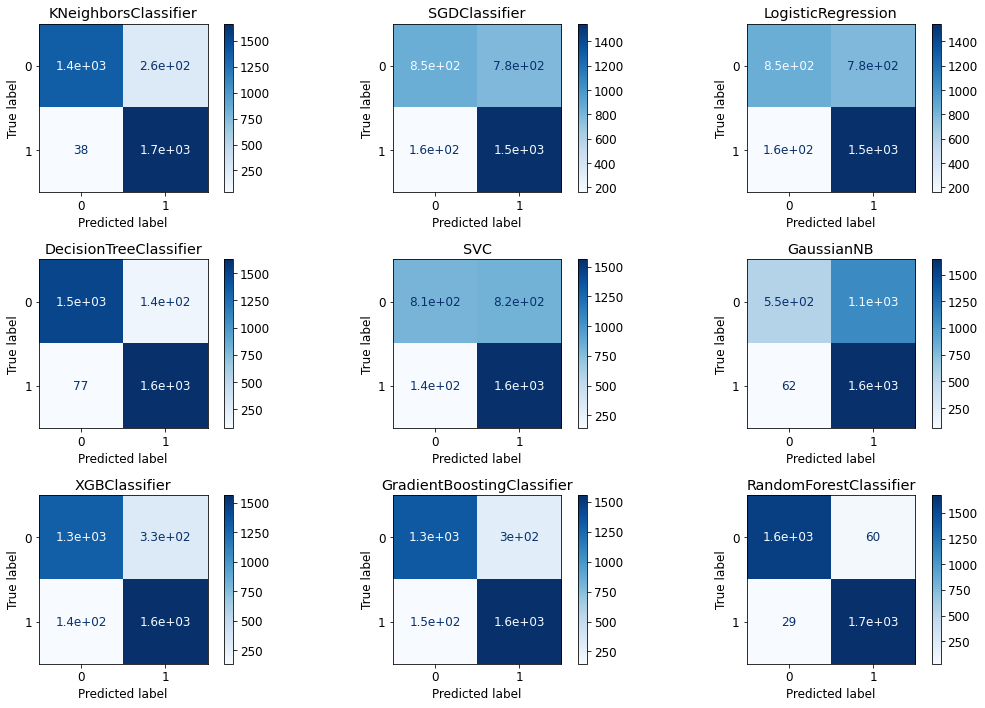

In [61]:
# confusion matrix

from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

classifiers = [KNeighborsClassifier(n_neighbors=3),
               SGDClassifier(),
               LogisticRegression(), 
               DecisionTreeClassifier(),
               SVC(kernel='linear'),
               GaussianNB(),
               XGBClassifier(),
               GradientBoostingClassifier(), 
               RandomForestClassifier(n_estimators=100)]

for cls in classifiers:
    cls.fit(x_train, y_train)
    
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15,10))

for cls, ax in zip(classifiers, axes.flatten()):
    plot_confusion_matrix(cls, 
                          x_test, 
                          y_test, 
                          ax=ax, 
                          cmap='Blues')
    ax.title.set_text(type(cls).__name__)
plt.tight_layout()  
plt.show()




In [62]:
# check the Precision, Recall and F1 score to better evaluate the performances of the models

from sklearn.metrics import classification_report

print('\033[1m  KNN  \033[0m')
print(classification_report(y_test, y_pred_knn))  # knn classification report
print("\n")

print('\033[1m  SGD  \033[0m')
print(classification_report(y_test, y_pred_sgd))  # sgd classification report
print("\n")

print('\033[1m  Log Regresion  \033[0m')
print(classification_report(y_test, y_pred_log))  # logistic classification report
print("\n")

print('\033[1m  DT  \033[0m')
print(classification_report(y_test, y_pred_dt))  # knn classification report
print("\n")

print('\033[1m  SVC  \033[0m')
print(classification_report(y_test, y_pred_svc))  # knn classification report
print("\n")

print('\033[1m  NB  \033[0m')
print(classification_report(y_test, y_pred_nb))  # knn classification report
print("\n")

print('\033[1m  XGBC  \033[0m')
print(classification_report(y_test, y_pred_xgbc))  # knn classification report
print("\n")

print('\033[1m  GB  \033[0m')
print(classification_report(y_test, y_pred_gb))  # knn classification report
print("\n")

print('\033[1m  RF  \033[0m')
print(classification_report(y_test, y_pred_rf))  # knn classification report
print("\n")

  KNN  
              precision    recall  f1-score   support

           0       0.97      0.84      0.90      1637
           1       0.87      0.98      0.92      1704

    accuracy                           0.91      3341
   macro avg       0.92      0.91      0.91      3341
weighted avg       0.92      0.91      0.91      3341



  SGD  
              precision    recall  f1-score   support

           0       0.85      0.51      0.64      1637
           1       0.66      0.91      0.77      1704

    accuracy                           0.72      3341
   macro avg       0.75      0.71      0.70      3341
weighted avg       0.75      0.72      0.70      3341



  Log Regresion  
              precision    recall  f1-score   support

           0       0.84      0.52      0.64      1637
           1       0.66      0.91      0.77      1704

    accuracy                           0.72      3341
   macro avg       0.75      0.71      0.71      3341
weighted avg       0.75      0.72   

<font size="4">
Based on the performance summary, several models stand out. They are KNN, DT, XGBC, RF.
</font>

### 4.6 Feature Importance

<font size="4">
Feature importance might be useful to check which feature is more important to predict the target.
</font>

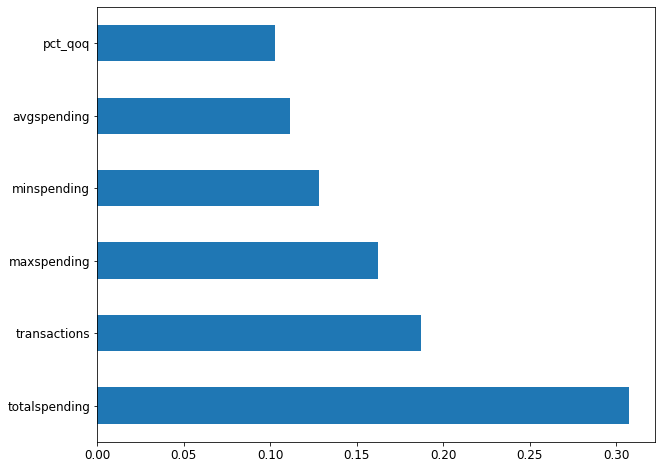

In [63]:
# RF model feature importance
plt.figure(figsize=(10,8))
feat_importances = pd.Series(rf_model.feature_importances_, index=df.columns[df.columns.str.contains('Churn')==False])
feat_importances.nlargest(50).plot(kind='barh')
plt.show()

### 4.7 ROC Curve

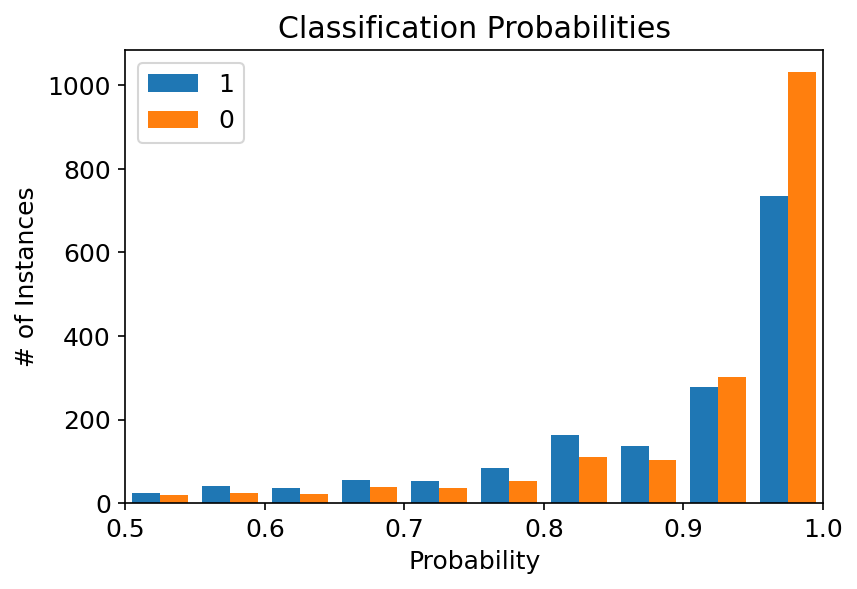

In [64]:
# get the probability distribution
probas = rf_model.predict_proba(x_test)

# plot
plt.figure(dpi=150)
plt.hist(probas, bins=20)
plt.title('Classification Probabilities')
plt.xlabel('Probability')
plt.ylabel('# of Instances')
plt.xlim([0.5, 1.0])
plt.legend(y_test)
plt.show()

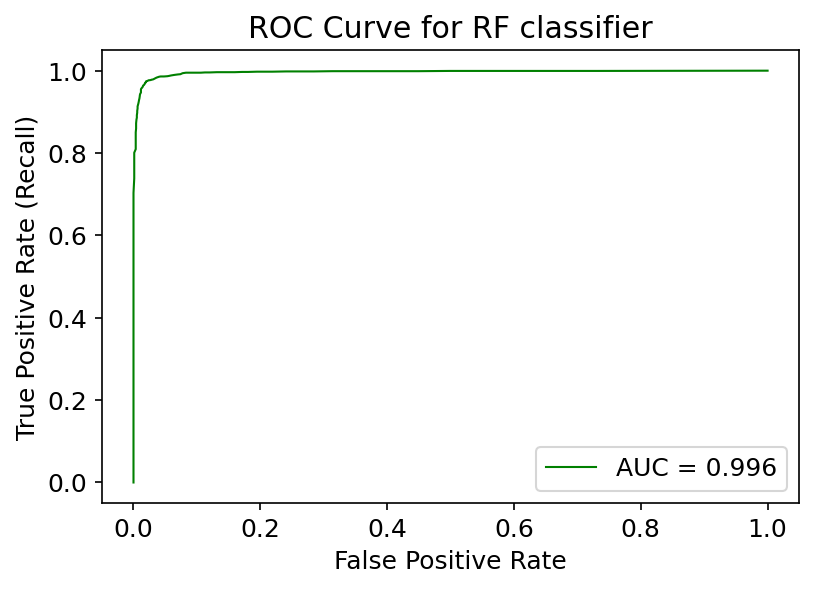

In [65]:
# ROC curve

from sklearn.metrics import roc_curve, auc

# get false and true positive rates
fpr, tpr, thresholds = roc_curve(y_test, probas[:,0], pos_label=0)

# get area under the curve
roc_auc = auc(fpr, tpr)

# PLOT ROC curve
plt.figure(dpi=150)
plt.plot(fpr, tpr, lw=1, color='green', label=f'AUC = {roc_auc:.3f}')
plt.title('ROC Curve for RF classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.legend()
plt.show()

## 5. Conclusion

<font size="4">

We set out to answer the questions: Can we build a model to predict the customer churn and what variables provide us the most information about the prediction? <br>
    
Given the exploration in this notebook, I conclude that Yes, we can create a model to accurately infer the potential churn of a customer and we have found the totalquarterlyspending, the numbers of transaction per quarter etc could be the most useful measures of determining the customer churn. <br>
    
The highlights from this work are:<br>
1. The payment data is re-processed and eningeered in a way ML models could be applied for prediction.<br>

2. RFM model is developed and customer segmentation is established.<br>

3. Churn is defined utilizing RFM and extensive feature engineering work completed for better model performance.<br>

4. Several ML models (KNN, DT, XGBC, RF) were able to achieve F1 score>0.95, which was significantly better than other models.<br>
    
5. If provided with data for a new customer, a trained model could accurately infer the potential churn.<br>
    
    <br>
    
This report also identified areas for follow-up. There could be a different way to summarize the transaction data (using monthly sales for example) or other feature engineering methods for better prediction.  
    
    
The author also want to thanks Bryan Bischof and Weights and Biases for the dataset, support and opportunity. </font>



In [66]:
# save the data to csv file
df.to_csv('payment1.csv', index=False)

# Thank you!

## 6. References


1. https://searchdatamanagement.techtarget.com/definition/RFM-analysis

2. https://towardsdatascience.com/recency-frequency-monetary-model-with-python-and-how-sephora-uses-it-to-optimize-their-google-d6a0707c5f17

3. https://towardsdatascience.com/imbalanced-classification-in-python-smote-enn-method-db5db06b8d50
